In [34]:
import mountaincar
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [74]:
def createTiling():    
    num_tiles = 10
    min_x = -1.2
    max_x = 0.5
    x_tile_width = (max_x - min_x) / (num_tiles - 2)
    min_y = -0.07
    max_y = 0.07
    y_tile_width = (max_y - min_y) / (num_tiles - 2)
    
    tilings = np.zeros((10, 2, 10))
    
    for tiling in range(num_tiles):
        x_offset = np.random.uniform(0, x_tile_width)
        y_offset = np.random.uniform(0, y_tile_width)     
        xs = np.linspace(min_x, max_x + x_tile_width, num_tiles) - x_offset
        ys = np.linspace(min_y, max_y + y_tile_width, num_tiles) - y_offset
        tilings[tiling] = np.array([xs, ys])
        
    return tilings

def genIndices(state, action, tilings):
    position = np.array(state[0])
    velocity = np.array(state[1])
    
    action_index = action + 1
    
    num_tilings = len(tilings)
    tiling_length = 10
    tiling_height = 10
    num_tiles = num_tilings * tiling_length * tiling_height
    
    tiles = np.zeros(10, dtype=np.intp)
    for tiling in range(num_tilings):
        xs = tilings[tiling][0]
        ys = tilings[tiling][1]
        xi = np.digitize(position, xs)
        yi = np.digitize(velocity, ys)
        index = (action_index * num_tiles) + (tiling * tiling_length * tiling_height) + xi + (yi * tiling_height)
        tiles[tiling] = int(index)
    return tiles


In [129]:
xs = np.linspace(-1.2, 0.5, 9)
print(xs)
ls = np.zeros(9)
for i in range(9):
    ls[i] = -1.2 + 0.17 * i
print(ls)

[-1.2    -0.9875 -0.775  -0.5625 -0.35   -0.1375  0.075   0.2875  0.5   ]
[-1.2  -1.03 -0.86 -0.69 -0.52 -0.35 -0.18 -0.01  0.16]


In [71]:
def e_greedy_action(theta, s, actions, tilings):
        Q = np.zeros(3)
        for a in actions:
            F = genIndices(s, a, tilings)
            Qa = calcQ(F, theta)
            Q[a + 1] = Qa
        maxQ = max(Q)
        if (Q == maxQ).sum() > 1:
            best = [i for i in range(len(actions)) if Q[i] == maxQ]
            i = random.choice(best)
        else:
            i = np.argmax(Q)
        action = actions[i]
        Qa = Q[i]
        return action, Qa

In [72]:
def calcQ(F, theta):
    Qa = 0
    for i in F:
        Qa = Qa + theta[i]
    return Qa

In [119]:
def play(env, num_episodes, alpha=0.1, gamma=1.0, epsilon=0.05, lambda_=0.9, plot=False):

    theta = np.zeros(3000)
    
    reward_per_episode = np.zeros(num_episodes)
    steps_per_episode = np.zeros(num_episodes)
    
    # Create tilings
    tilings = createTiling()
    
    for episode in range(num_episodes):
        
        cumulative_reward = 0
        step = 0

        e = np.zeros(3000)
        env.reset()
        
        # Get starting state and action
        state = np.array([env.position, env.velocity])
        action = random.choice(env.actions)
        
        while not env.game_over:
            
            F = genIndices(state, action, tilings)
            
            # Eligibility traces
            for i in F:
                #e[i] = 1 # Accumulating traces
                e[i] = 1 # Replacing traces
            
            # Make step and get reward and next state
            reward = env.make_step(action)
            state_ = np.array([env.position, env.velocity])
            
            # Calculate Q and then TD error
            Qa = calcQ(F, theta)
            #print(Qa)
            delta = reward - Qa
            
            # Epsilon greedy next action choice
            if np.random.uniform(0, 1) < (1 - epsilon):
                action_, Qa_ = e_greedy_action(theta, state_, env.actions, tilings)
            else:
                action_ = random.choice(env.actions)
                F = genIndices(state_, action, tilings)
                Qa_ = calcQ(F, theta)
            
            # Update delta, theta and e
            delta = delta + gamma * Qa_
            theta = theta + alpha * delta * e
            #print(max(theta))
            e = gamma * lambda_ * e
            
            # Set s = s' and a = a'
            state = np.copy(state_)
            action = action_
            
            # Increment step counter and cumulative reward
            step += 1
            cumulative_reward += reward
            
            # Plot graph if plot boolean on
            if plot == True:
                env.plot()
                
        reward_per_episode[episode] = cumulative_reward
        steps_per_episode[episode] = step
    
    print("complete")
    return reward_per_episode, steps_per_episode
            

In [131]:
n_agents = 10
num_episodes = 100
all_rewards = np.zeros(num_episodes)
all_steps = np.zeros(num_episodes)
for i in range(n_agents):
    #sarsa_agent = SarsaAgent(alpha=0.1, gamma=1.0, epsilon=0.05, lambda_=0.9)
    env = mountaincar.MountainCar()
    rewards, steps = play(env, num_episodes, alpha=0.125, gamma=1.0, epsilon=0.0, lambda_=0.9, plot=False)
    all_rewards += rewards
    all_steps += steps

all_rewards = all_rewards / n_agents
all_steps = all_steps / n_agents

complete
complete
complete
complete
complete
complete
complete
complete
complete
complete


In [118]:
n_agents = 10
num_episodes = 100
all_rewards_001 = np.zeros(num_episodes)
all_steps_001 = np.zeros(num_episodes)
for i in range(n_agents):
    env = mountaincar.MountainCar()
    rewards, steps = play(env, num_episodes, alpha=0.1, gamma=1.0, epsilon=0.0, lambda_=0.9, plot=False)
    all_rewards_001 += rewards
    all_steps_001 += steps

all_rewards_001 = all_rewards_001 / n_agents
all_steps_001 = all_steps_001 / n_agents

complete
complete
complete
complete
complete
complete
complete
complete
complete
complete


In [ ]:
play(env, num_episodes, alpha=0.1, gamma=1.0, epsilon=0.05, lambda_=0.9, plot=True)

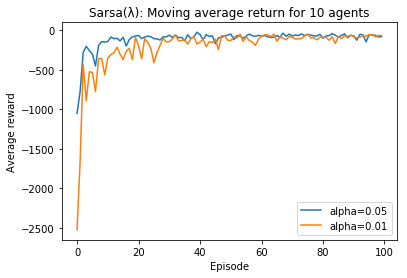

In [114]:
#print(all_rewards)

plt.plot(all_rewards, label='alpha=0.05')
plt.plot(all_rewards_001, label='alpha=0.01')
plt.title("Sarsa(λ): Moving average return for "+ str(n_agents) + " agents")
plt.xlabel('Episode')
plt.ylabel('Average reward')
plt.legend()
plt.show()